### Aim :
- To predict / forecast monthly microbusiness density in a given area.
- It is a **Time Series Analysis** problem.

### Dataset Attributes :

- This competition has provided 3 csv files :
    - **train.csv** : 
        - **row_id** : An ID code for the row.
        - **cfips** : A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
        - **county_name** : The written name of the county.
        - **state_name** : The name of the state.
        - **first_day_of_month** : The date of the first day of the month.
        - **microbusiness_density** : Microbusinesses per 100 people over the age of 18 in the given county. 
            This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
        - **active** : The raw count of microbusinesses in the county. Not provided for the test set.

    - **census_starter.csv** : Examples of useful columns from the Census Bureau's American Community Survey (ACS) at data.census.gov. The percentage fields were derived from the raw counts provided by the ACS. All fields have a two year lag to match what information was avaiable at the time a given microbusiness data update was published. 
         - **pct_bb_[year]** : The percentage of households in the county with access to broadband of any type. Derived from ACS table B28002: PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD.
        - **cfips** : The CFIPS code.
        - **pct_college_[year]** : The percent of the population in the county over age 25 with a 4-year college degree. Derived from ACS table S1501: EDUCATIONAL ATTAINMENT.
        - **pct_foreign_born_[year]** : The percent of the population in the county born outside of the United States. Derived from ACS table DP02: SELECTED SOCIAL CHARACTERISTICS IN THE UNITED STATES.
        - **pct_it_workers_[year]** : The percent of the workforce in the county employed in information related industries. Derived from ACS table S2405: INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER.
        - **median_hh_inc_[year]** : The median household income in the county. Derived from ACS table S1901: INCOME IN THE PAST 12 MONTHS (IN 2021 INFLATION-ADJUSTED DOLLARS).

    - **test.csv** :
        - **row_id** : An ID code for the row.
        - **cfips** : A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
        - **first_day_of_month** : The date of the first day of the month.
        
    - **sample_submission.csv** : A valid sample submission. This file will remain unchanged throughout the competition.
        - **row_id** : An ID code for the row.
        - **microbusiness_density** : The target variable.

### Notebook Contents :
- Dataset Information
- Time Series Analysis
- **Approach 1** : Model definitions of AR, MA, ARMA, ARIMA & SARIMA with no order tuning. 
- **Approach 2** : AR, MA, ARMA, ARIMA & SARIMA models tuned with single order value for 3135 unique cfips based time series.
- **Approach 3** : Auto Arima model with unique order value for 3135 unique cfips based time series.
- **Approach 4** : AR, MA, ARMA, ARIMA & SARIMA models with unique order values generated from Auto Arima for 3135 unique cfips based time series.
- **Approach 5** : AR, MA, ARMA, ARIMA & SARIMA models tuned with single order value for 3135 unique cfips based time series with the support of Endogenous - Exogenous variables.
- **Approach 6** : Auto Arima model with unique order value for 3135 unique cfips based time series with the support of Endogenous - Exogenous variables.
- **Approach 7** : AR, MA, ARMA, ARIMA & SARIMA models with unique order values generated from Auto Arima for 3135 unique cfips based time series with the support of Endogenous - Exogenous variables.
- Conclusion

### What you will learn :
- Statistical Tests for Time Series Analysis.
- AR, MA, ARMA, ARIMA, SARIMA & Auto Arima models.
- Endogenous & Exogenous variables.
- Out-of-sample forecasting using rolling & non-rolling methods using predict and forecast function.

### Lets get started!

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Dataset Information</div></center>

### Import the Necessary Libraries : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import pickle

from itertools import combinations
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

### Accessing CSV Files :

In [2]:
train = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/train.csv')
test = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/test.csv')
census = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv')
sample = pd.read_csv('/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Time Series Analysis</div></center>

In [4]:
data = train[['first_day_of_month', 'microbusiness_density']].copy(deep = True)
data['Date'] = pd.to_datetime(data['first_day_of_month'])
data = data.drop(columns = 'first_day_of_month')
data = data.set_index('Date')
data.head()

,microbusiness_density
Date,
2019-08-01,3.01
2019-09-01,2.88
2019-10-01,3.06
2019-11-01,2.99
2019-12-01,2.99


- Creating a copy of the dataset consisting of the 2 features : **first_day_of_month** & **microbusiness_density**
- Converting the datatype of the **first_day_of_month** column to datetime datatype and setting it as the index of the dataset.
- Renaming the column **first_day_of_month** to **Date**!
- It is a monthly distributed data.

In [5]:
data = data.groupby(data.index).mean()
data.head()

,microbusiness_density
Date,
2019-08-01,3.75
2019-09-01,3.70
2019-10-01,3.78
2019-11-01,3.72
2019-12-01,3.72


- Originally the **train** dataset provided had data of **3135** unique **county - state** combination of **39 months**.
- We use **groupby** according to the **Date** feature. This helped us to eliminate the duplicates from the data.
- Now, we only have 39 values for modeling with **2019-08-01** being the 1st value and **2022-10-01** being the last date value.

### Supportive Functions for Time Series Analysis :

In [6]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

### Components of Time Series :
- A Time Series consists of the following components :

    - **Trend** : Long term direction of the data.
    
    **E.g** : Year on year rising temperature of the Earth due to Global Warming.
    
    - **Seasonality** : Short term repetitve patterns of the data due to the weather seasons.
    
    **E.g** : Sale of sweaters specifically in the winter season.
    
    - **Cyclic Variations** : Short term repetitive patterns of the data over a period of 1 year.
    
    **E.g** : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.
    
    - **Irregularities** : Random and unforseen fluctuations in the data.
    
    **E.g** : Occurrences of Earthquakes or Floods, etc.
    
    
- **In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.** 

Let's visualize the **mircobusiness_density** data for the above components!
- For this purpose, we use a function **seasonal_decompose** from the **statsmodel** library.
- This function has a parameter, **model**, that needs to be assigned the value **additive** or **multiplicative**.
    - **Additive Model** : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
    - **Multiplicative Model** : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

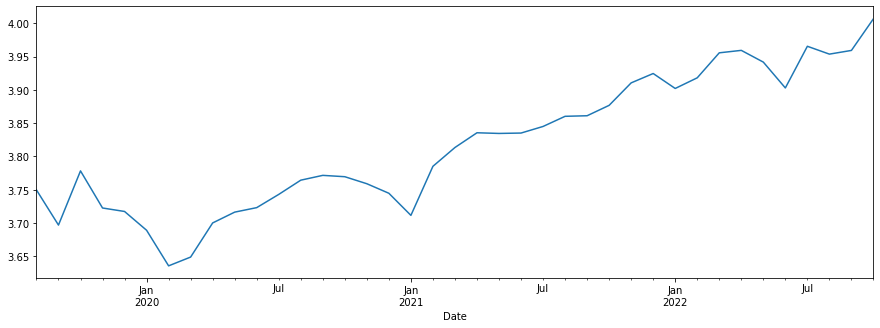

In [8]:
plt.figure(figsize = (15,5))
data['microbusiness_density'].plot();

- From the above graph, a clear information about the **seasonality** cannot be understood. Dips in values near the month of **January** can be found.
- Whereas, a clear rising upward trend can be observed. Thus, we will use the **Additive model** value to divide the series for extracting more information.

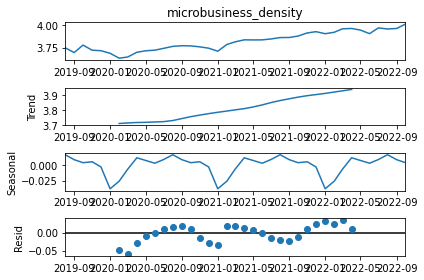

In [9]:
dec = sm.tsa.seasonal_decompose(data['microbusiness_density'],period = 12,model = 'additive').plot()
plt.show()

- Data clearly has a **linear uptrend**.
- A **seasonal** pattern of a 1 year duration is present in the data. Dips in value near the month of **January** followed by troughs & crests in the months of **May - July**.
- We also need to check the statistical parameters w.r.t time. 

### Stationarity :

- **Stationarity** is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
- For a time series, features are dependent on time i.e **features are a function of time**. Statistical paramters will change values over time as they are extracted from the features.
- If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
- Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.
- To test stationarity, we will use **Augmented Dickey Fuller Test** : 
    - **Null Hypothesis** : It assumes that the time series is non-stationary.
    - **Alternate Hypothesis** : If the null hypothesis is rejected, then the time series is stationary.
    - Output of the **Augmented Dickey Fuller Test** include :
        - **Test Statistic**
        - **p-value**
        - **#Lags Used**
        - **Number of Observations Used**
        - **Critical Value (1%)**
        - **Critical Value (5%)**
        - **Critical Value (10%)**
- For the **Null Hypothesis** to be rejected and accepting that the time series is stationary, there are 2 requirements :
    - **Critical Value (5%)** > **Test Statistic**
    - **p-value** < 0.05

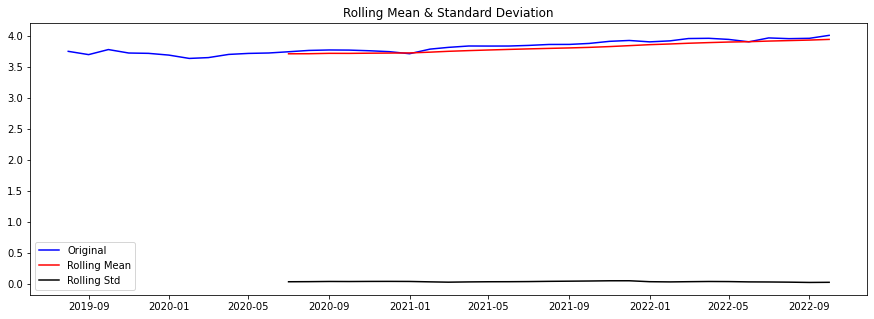

Results of Dickey-Fuller Test:
Test Statistic                -0.18
p-value                        0.94
#Lags Used                     0.00
Number of Observations Used   38.00
Critical Value (1%)           -3.62
Critical Value (5%)           -2.94
Critical Value (10%)          -2.61
dtype: float64


In [10]:
test_stationarity(data['microbusiness_density'])

- For the **microbusiness_density** time series data, 
    - **Rolling Mean** is variable with time. 
    - **Rolling Standard Deviation** is pretty much flat.
    - **Test Statistic : (-0.18)** > **Critical Value (5%) : (-2.94)**
    - **p-value (0.94)** > 0.05
- Hence, **Null Hypothesis** cannot be rejected and we can conclude that the above time series is **not stationary**.
- In order to eliminate trend, seasonality and make the time series stationary, we will use **differencing** i.e subtracting the previous value from it's next value.

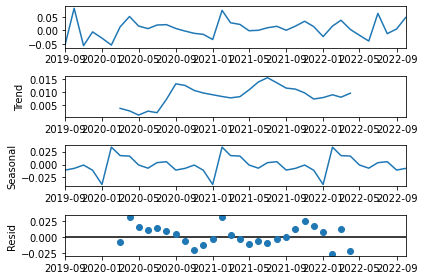

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

- **Trend** of the data has near about died down & their values have been reduced as well. However, **Seasonality** of the data is present but with insignificant numbers.
- We now check the **stationarity** of the time series.

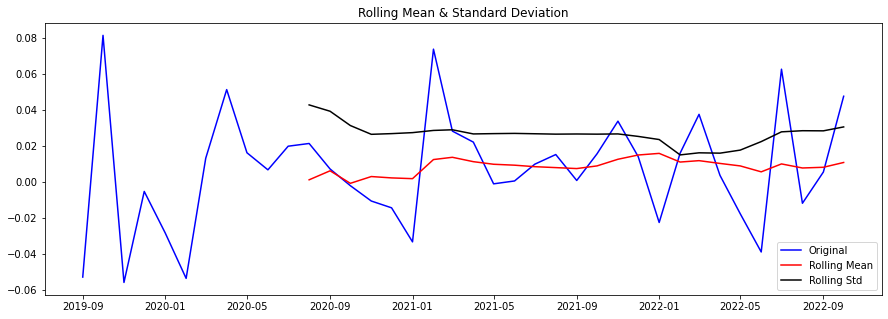

Results of Dickey-Fuller Test:
Test Statistic                -4.59
p-value                        0.00
#Lags Used                     1.00
Number of Observations Used   36.00
Critical Value (1%)           -3.63
Critical Value (5%)           -2.95
Critical Value (10%)          -2.61
dtype: float64


In [12]:
test_stationarity(data_diff)

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** is very close to 0 as well.
    - **Test Statistic : (-4.59)** < **Critical Value (5%) : (-2.95)**. 
    - **p-value (0.00)** < **0.05**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**. 
- For any **Time Series Analysis** problem, series being **stationary** is very critical as majority of the models assume stationarity, trend & seasonality have been dealt with!

**We will now move on to different approaches!**

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 1</div></center>

- This is a completely naive approach towards this problem where we create a simple time series analysis models ignoring all the other features especially **cfips** & **county**.
- In this approach, we will create the initializations for the following models :
    - **Auto Regression (AR)**
    - **Moving Average (MA)**
    - **Auto Regressive Moving Average (ARMA)**
    - **Auto Regressive Integrated Moving Average (ARIMA)**
    - **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**
- We will just acknowledge the performances generated by these models and then move onto certain variations in order to improve the score.

## <center>AR</center> 
### <center>Auto Regression</center> 

- **Auto Regression (AR)** is the kind of model that uses data from the same input variable at previous time steps. 
- It's principle in predicting the future values is that observations at previous time steps are very significant in predicting the values in the future.
- This relationship between observations is known as correlation. There are 2 types of correlation :
    - **Positive Correlation : Both values of the observations move in the same direction**
    - **Negative Correlation : Both values of the observations move in the opposite direction**
- Since the relation between observations at the present times and those in the past times (**lag values**) is calculated, it is known as **Autocorrelation**.
- The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

**We will now check the plots for the differenced time series i.e stationary in nature!**

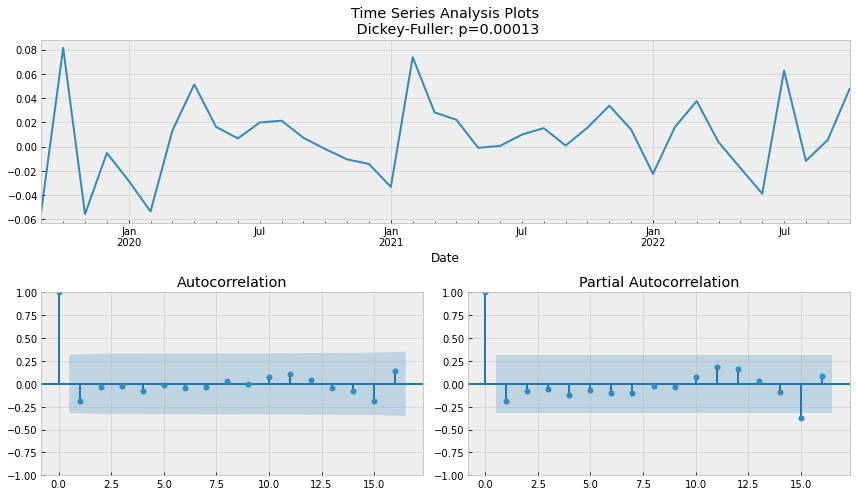

In [13]:
tsplot(data_diff['microbusiness_density'])

- In the above plots of correlations, we can see the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis along with a confidence interval (blue region) for the correlation values. 
- Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant or significant lag values for predicting future values.
- From the above graph, we can see that none of the lags are significant and hence we will have to select **AR (p) : 0**.
- For modeling of AR, we will use the **ARIMA** model initialization where we set the order **(p, d, q)** as **(p, 0, 0)**. We the set orders of **d & q : 0** as we only want to make use of the **AR (p)** model in this case.

In [14]:
model = ARIMA(data['microbusiness_density'],order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  34.482
Date:                   Thu, 16 Feb 2023   AIC                            -64.964
Time:                           13:24:10   BIC                            -61.637
Sample:                       08-01-2019   HQIC                           -63.770
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8177      0.016    236.742      0.000       3.786       3.849
sigma2         0.0100      0.004      2.835      0.005       0.003       0.017
Ljung-Box (L1) (Q):         

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- [AutoReg](https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html) is a readymade option available as well for **AR modeling**.

## <center>MA</center> 
### <center>Moving Average</center> 

- **Moving Average (MA)** is the kind of model that assumes the current value is linearly dependent on the current and past error terms.
- In this model, a rolling window i.e a specific number of values are averaged that assist in predicting the future values. Order of the model governs the mathematical fomula used for forecasting.  
- In order to find the order of the MA model, autocorrelation graph is looked at by assuming the time series has been made stationary.
- We try to find the significant lags from the plot i.e lag values that are outside the confidence interval and the lags succeding it becomes redundant by staying the confidence interval.
- If none of the significant lags are found, MA model becomes redundant and it is known as **random walk**.

**We will now check the plots for the differenced time series i.e stationary in nature!**

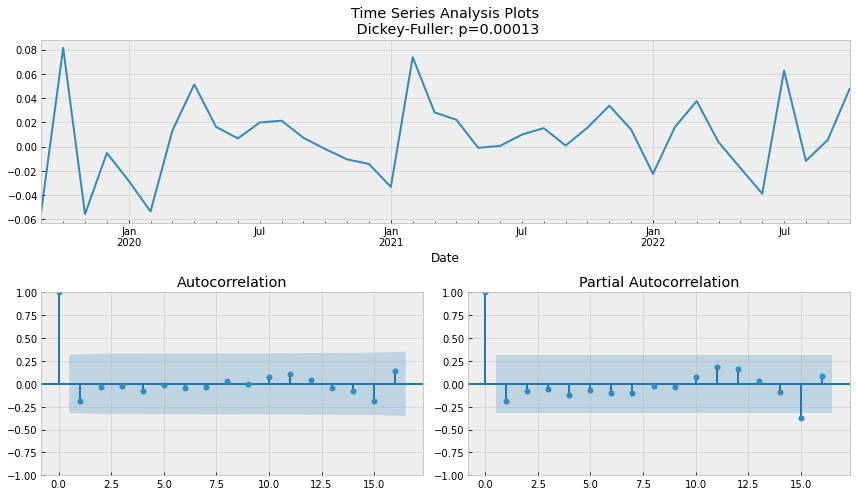

In [15]:
tsplot(data_diff['microbusiness_density'])

- Similar to AR models, none of the lags are significant and hence we will have to select **MA (q) : 0**.
- We use the **ARIMA** model initialization & of **d & q : 0**.

In [16]:
model = ARIMA(data['microbusiness_density'],order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  34.482
Date:                   Thu, 16 Feb 2023   AIC                            -64.964
Time:                           13:24:21   BIC                            -61.637
Sample:                       08-01-2019   HQIC                           -63.770
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8177      0.016    236.742      0.000       3.786       3.849
sigma2         0.0100      0.004      2.835      0.005       0.003       0.017
Ljung-Box (L1) (Q):         

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## <center>ARMA</center> 
### <center>Auto Regressive - Moving Average</center> 

- As the name suggests, it is a combination of the previous 2 models:
    - **Auto Regression (p)**
    - **Moving Average (q)**
- It utilizes the features of these models for forecasting.
- It's order only has 2 parameters (p, q) from the 2 models. Order selection of these 2 models is same as the above 2 models.
- From the previous 2 models, we set the order as **(0, 0)**.

In [17]:
model = ARIMA(data['microbusiness_density'],order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  34.482
Date:                   Thu, 16 Feb 2023   AIC                            -64.964
Time:                           13:24:29   BIC                            -61.637
Sample:                       08-01-2019   HQIC                           -63.770
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8177      0.016    236.742      0.000       3.786       3.849
sigma2         0.0100      0.004      2.835      0.005       0.003       0.017
Ljung-Box (L1) (Q):         

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- We use the initlialization of **ARIMA** due to the latest updates!

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

- **ARIMA** model is a combination of 3 models :
    - **AR (p) : Auto Regressive**
    - **I (d) : Integrated**
    - **MA (q) : Moving Average**

- **(p,d,q)** is known as the order of the **ARIMA** model. Values of these parameters are based on the above mentioned models.  
    - **p** : Number of auto regressive terms. 
    - **d** : Number of differencing orders required to make the time series stationary.
    - **q** : Number of lagged forecast errors in the prediction equation.

- Selection criteria for the order of **ARIMA** model : 
    - **p** : Lag value where the **Partial Autocorrelation (PACF)** graph cuts off or drops to 0 for the 1st instance.
    - **d** : Number of times differencing is carried out to make the time series stationary.
    - **q** : Lag value where the **Autocorrelation (ACF)** graph crosses the upper confidence interval for the 1st instance.

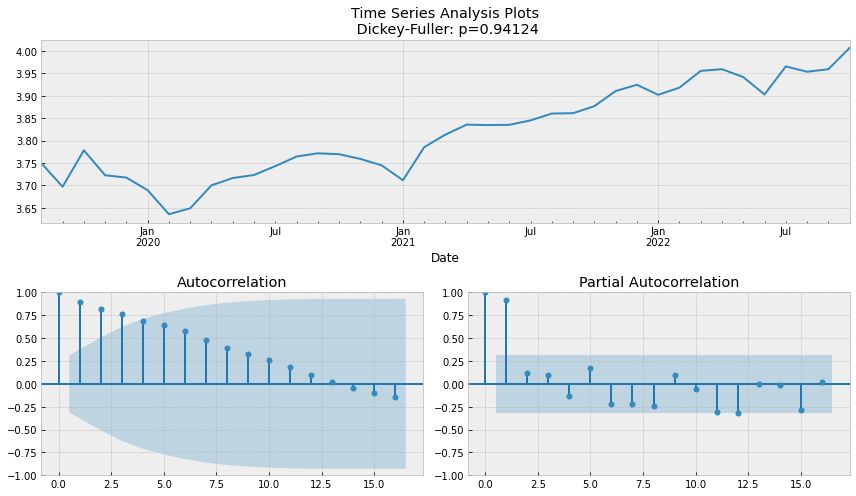

In [18]:
tsplot(data['microbusiness_density'])

- **ACF** graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- **PACF** graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.
- From the **PACF** graph above, the 1st lag is out of the confidence interval and probably the most significant lag. It probably dictates the pattern for the **ACF** graph where the next lag follows it's previous lag.
- From the **PACF** graph, 1st lag is outside the confidence interval (blue region) i.e every else lag has some differentiable or predictable pattern. 

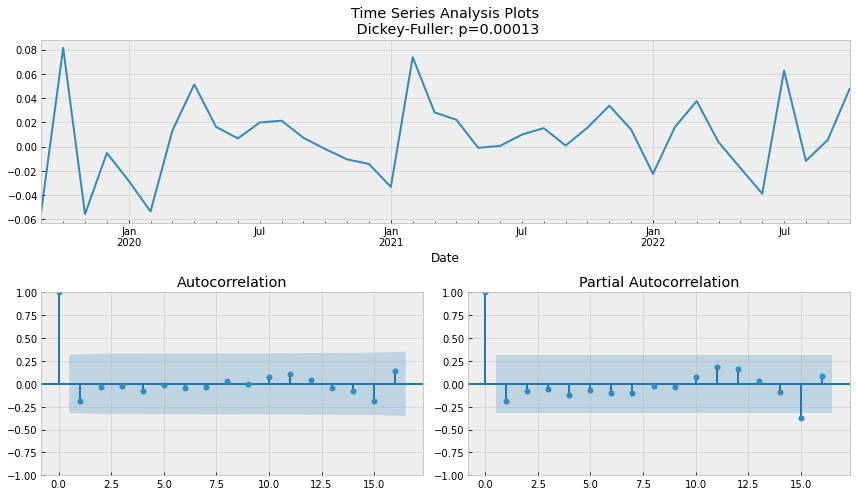

In [19]:
tsplot(data_diff['microbusiness_density'])

- From the above plots, the following order of **ARIMA** model is selected from the selection criteria mentioned above :
    - **p** : 0
    - **d** : 1
    - **q** : 0
- This is because after making the time series free from stationarity, trend & seasonality, none of the significant lags are present. We will now pass the data for model fitting that is non-differenced data and non-stationary data.
- In order to make the series stationary, we difference the time series. Thus, this differencing of data is carried out by the ARIMA model with the help of the **d** parameter that provides info about the order of differencing.
- Thus, the parameters **p** and **q** are selected in such a way that we pass their values assuming the ARIMA model carries out the differencing process and makes the time series stationary.

In [20]:
model = ARIMA(data['microbusiness_density'],order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 1, 0)   Log Likelihood                  76.040
Date:                   Thu, 16 Feb 2023   AIC                           -150.080
Time:                           13:24:42   BIC                           -148.442
Sample:                       08-01-2019   HQIC                          -149.497
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0011      0.000      4.494      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):                 0.13
Prob(Q):               

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

- **SARIMA** model is an extension of the ARIMA model that can handle the seasonal effects of the data.
- It has kind of 2 orders **(p,d,q) x (P,D,Q,M)**. 
- **(p,d,q)** is the order that is similar to the order of the **ARIMA** model. 
- **(P,D,Q,M)** is known as the Seasonal Order where **(P,D,Q)** are similar to the **(p,d,q)** of the ARIMA model. 
- It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, **M** and check the **PACF** & **ACF** values at the **Mth** lag value. 

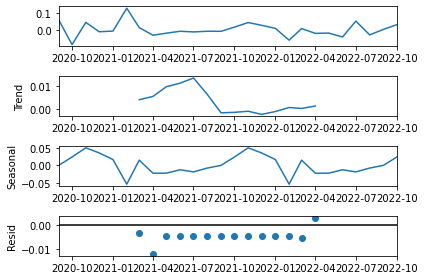

In [21]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

- Our data is in **monthly format** and the **seasonal period is of 1 year**.
- Hence, we difference the already differenced data by a periodicity, **M**, value of 12.
- The seasonality of the data has not completely died down but it's values have been dropped.
- We will check this seasonal differenced data for stationarity.

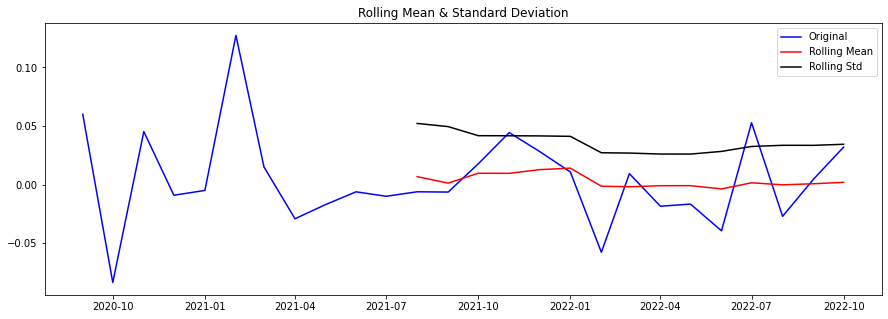

Results of Dickey-Fuller Test:
Test Statistic                -6.18
p-value                        0.00
#Lags Used                     0.00
Number of Observations Used   25.00
Critical Value (1%)           -3.72
Critical Value (5%)           -2.99
Critical Value (10%)          -2.63
dtype: float64


In [22]:
test_stationarity(data_diff_seas['microbusiness_density'])

- From the outputs of the **Augmented Dickey Fuller Test**,
    - **Rolling Mean** is very close to 0.
    - **Rolling Standard Deviation** is very close to 0.
    - **Critical Value (5%) : (-2.99)** > **Test Statistic : (-6.18)**. We can say that the time series is **stationary with 99%** confidence as the **Test Statistic** is less than **Critical Value (1%)** as well.
    - **0.05** > **p-value (0.00)**
- From these outputs, we can reject the **Null Hypothesis** and accept the **Alternate Hypothesis** i.e we can say that the above **time series is stationary**.

In [23]:
# tsplot(data_diff_seas['microbusiness_density'])

- For the **SARIMA** model, order of **(p,d,q)** will be same as the order of the **ARIMA** model above. 
- For **(P,D,Q,M)** :
    - **P** : 0
    - **D** : 1
    - **Q** : 0
    - **M** : 12

In [24]:
model = sm.tsa.statespace.SARIMAX(data['microbusiness_density'],order = (0,1,0),seasonal_order = (0,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15092D+00    |proj g|=  9.93640D+00

At iterate    5    f= -1.18243D+00    |proj g|=  7.52224D-04
  ys=-6.204E-10  -gs= 6.895E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      7     52      3     1     0   1.075D-03  -1.182D+00
  F =  -1.1824304067263394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                            

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 1</div></center>

### Out - of - Sample Forecasting :

- **Out - of - Sample Forecasting** : Model forecasts values for the future data points by imputing the datetime index values of the time series.
- We create a new dataframe that is the copy of the test dataset. 
- For this **Out - of - Sample Forecasting**, we use the **rolling** method as well as the **non-rolling** method by using **forecast function** & **predict function**.
- In the **rolling** method, we forecast or predict the next single value, use this predicted value again for model fitting that is then used for predicting the next value.
- In the **non-rolling** method, we forecast or predict the bunch of values in a single instance.
-  We will repeat this preprocessing process for **test data** for the remaining approaches as well.

In [25]:
test['first_day_of_month'] = pd.to_datetime(test['first_day_of_month'])
df1 = test.copy(deep = True)
df1 = df1.set_index('first_day_of_month')
df1 = df1.groupby(df1.index).mean()
df1

,cfips
first_day_of_month,
2022-11-01,30376.04
2022-12-01,30376.04
2023-01-01,30376.04
2023-02-01,30376.04
2023-03-01,30376.04
2023-04-01,30376.04
2023-05-01,30376.04
2023-06-01,30376.04


- In the **test** data, after using **groupby**, we only have 8 new month values from **2022-11-01** to **2023-06-01**.
- Hence, we only have to forecast the next 8 values but the **test** data has 25080 entries.
- Thus, in order to match this, we create a copy of the test dataset, convert the **first_day_of_month** feature to datetime & assign it as the index of this copy dataframe.
- We now use the **rolling forecast** to predict the next 8 values.

## Rolling Predictions : 

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Forecast Function : 

In [26]:
history_f = [x for x in data['microbusiness_density']]
f1 = []

for t in tqdm(range(len(df1))):
    
    model = ARIMA(history_f, order = (0,0,0)) # AR
    model = ARIMA(history_f, order = (0,0,0)) # MA
    model = ARIMA(history_f,order = (0,0,0)) # ARMA
    model = ARIMA(history_f, order = (0,1,0)) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()
    
    output = model_fit.forecast()[0]
    
    history_f.append(output)
    f1.append(output)

df1['forecast'] = 0
for i in range(len(f1)):
    df1.iloc[i, 1] = f1[i]

df1

#### Predict Function : 

In [27]:
history_p = [x for x in data['microbusiness_density']]
p1 = []

for t in tqdm(range(len(df1))):
    
    model = ARIMA(history_p, order = (0,0,0)) # AR
    model = ARIMA(history_p, order = (0,0,0)) # MA
    model = ARIMA(history_p,order = (0,0,0)) # ARMA
    model = ARIMA(history_p, order = (0,1,0)) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_p,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(history_p),end = len(history_p))[0]
    
    history_p.append(output)
    p1.append(output)

df1['forecast'] = 0
for i in range(len(p1)):
    df1.iloc[i, 1] = p1[i]

df1

## Non-Rolling Predictions :

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**

#### Forecast Function : 

In [28]:
df1['forecast'] = 0
f2 = np.array(model_fit.forecast(steps = 8))

for i in range(len(f2)):
    df1.iloc[i,1] = f2[i]
df1

#### Predict Function : 

In [29]:
df1['forecast'] = 0
p2 = np.array(model_fit.predict(start = 39,end = 46))

for i in range(len(p2)):
    df1.iloc[i, 1] = p2[i]
df1

- We have now forecasted for the 8 months present in the **test** data but the submission file needs to have 25080 rows in it!
- Hence, to solve this part, we create another copy of the **test** data, convert the **first_day_of_month** feature to datetime & assign it as the index of the dataframe.
- We do not use **groupby** here and hence we retain all the 25080 rows of the **test** data.
- Then we assign the **forecast values** from the above the copied dataframe to this newly created dataframe. **As the both the dataframes have the same indexes**, we do not have to worry about mistmatch in lengths of the dataframes as well as the matching of the values.
- Once this matching of values is done, we reassign the index of this dataframe by changing them from the datetime values to integers.
- Finally for submission, we create a complete new dataframe and pick out the 2 columns from the very recently created dataframe & assign it to this dataframe & submit.

In [30]:
df2 = test.copy(deep = True)
df2 = df2.set_index('first_day_of_month')
df2['forecast'] = df1['forecast']
df2.index = range(len(df2))

submission = pd.DataFrame({'row_id':df2['row_id'],'microbusiness_density':df2['forecast']})
submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 2</div></center>

- For this approach, we create time series analysis models that use the feature of **cfips** for forecasting.
- In this approach, we will only create the initializations for the following models :
    - **Auto Regression (AR)**
    - **Moving Average (MA)**
    - **Auto Regressive - Moving Average (ARMA)**
    - **Auto Regressive Integrated Moving Average (ARIMA)**
    - **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**
- For all the unique values of **cfips**, we will create unique models & forecast the values using the same order of models that we found from the **Aproach 1**.

In [31]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density
cfips Date                             
1001  2019-08-01                   3.01
      2019-09-01                   2.88
      2019-10-01                   3.06
      2019-11-01                   2.99
      2019-12-01                   2.99

- Creating a copy of the **train** dataset consisting of the 3 features : **first_day_of_month**, **microbusiness_density** & **cfips**.
- Converting the datatype of the **first_day_of_month** column to datetime datatype and setting it as the index of the dataset.
- We rename the column **first_day_of_month** to **Date**. It is a monthly distributed data.
- We use **groupby** according to the **cfips** & **Date** features.
- Now, we 3135 unique **cfips** values with each consisting of 39 **date** values for **microbusiness_density**. 
- Hence we now aim to create models for each individual 3135 unique **cfips** values.
-  We will repeat this preprocessing process of **train data** for the remaining approaches as well. This step is different than the process used in the **Approach 1**. 

## <center>AR | MA | ARMA</center> 
### <center>Auto Regression | Moving Average | Auto Regressive - Moving Average</center> 

In [32]:
model = ARIMA(df1.loc[1001,:],order = (0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                             ARIMA   Log Likelihood                  15.649
Date:                   Thu, 16 Feb 2023   AIC                            -27.297
Time:                           13:26:37   BIC                            -23.970
Sample:                       08-01-2019   HQIC                           -26.104
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1645      0.026    121.286      0.000       3.113       3.216
sigma2         0.0262      0.009      3.007      0.003       0.009       0.043
Ljung-Box (L1) (Q):         

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- For representation, we have modelled the above model for **cfips : 1001**!
- We keep the same **AR - MA - ARMA model order** as we discovered from **Approach 1** for all individual models of unique **cfips** values.

## <center>ARIMA</center> 
### <center>Auto Regressive Integrated Moving Average</center> 

In [33]:
model = ARIMA(df1.loc[1001,:],order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     microbusiness_density   No. Observations:                   39
Model:                    ARIMA(0, 1, 0)   Log Likelihood                  50.188
Date:                   Thu, 16 Feb 2023   AIC                            -98.375
Time:                           13:26:41   BIC                            -96.738
Sample:                       08-01-2019   HQIC                           -97.793
                            - 10-01-2022                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0042      0.001      5.324      0.000       0.003       0.006
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):                 1.68
Prob(Q):               

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


- For representation, we have modelled the above model for **cfips : 1001**!
- We keep the same **ARIMA model order** as we discovered from **Approach 1** for all individual models of unique **cfips** values.

## <center>SARIMA</center>
### <center>Seasonal Auto Regressive Integrated Moving Average</center> 

In [34]:
model = sm.tsa.statespace.SARIMAX(df1.loc[1001,:],order = (0,1,0),seasonal_order = (0,1,0,12))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.23113D-01    |proj g|=  4.50075D+00

At iterate    5    f= -6.54625D-01    |proj g|=  3.88771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5     13      1     0     0   3.888D-04  -6.546D-01
  F = -0.65462454397004033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:              microbusiness

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


- Similar to **ARIMA**, **SARIMA** has also been modelled for **cfips : 1001**!
- **SARIMA model order** is same that we used in **Approach 1** for all individual models of unique **cfips** values.

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 2</div></center>

In [35]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

- We repeat the preprocessing process for **test data** w.r.t **cfips**.

### Rolling Predictions : 

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Forecast Function : 

In [36]:
df2['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df1.loc[int(i),:].values]
    f1 = []

    for t in range(len(df2.loc[int(i),:])):

        model = ARIMA(history_f, order = (0,0,0)) # AR - MA - ARMA
        model = ARIMA(history_f, order = (0,1,0)) # ARIMA
        model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
        model_fit = model.fit()

        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df2.loc[int(i), 'microbusiness_density'] = f1[j]

df2.index = range(0,len(test))

#### Predict Function : 

In [37]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[int(i),:].values]
    f1 = []

    for t in range(len(df2.loc[int(i),:])):

        model = ARIMA(history_p, order = (0,0,0)) # AR - MA - ARMA
        model = ARIMA(history_p, order = (0,1,0)) # ARIMA
        model = sm.tsa.statespace.SARIMAX(history_p,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
        model_fit = model.fit()

        output = model_fit.predict(start = len(history_p),end = len(history_p),typ = 'levels')[0]

        history_p.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df2.loc[int(i), 'microbusiness_density'] = f1[j]
        
df2.index = range(0,len(test))

## Non-Rolling Predictions :

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Forecast Function : 

In [38]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_f = [x[0] for x in df1.loc[int(i),:].values]
    model = ARIMA(history_f, order = (0,0,0)) # AR - MA - ARMA
    model = ARIMA(history_f, order = (0,1,0)) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_f,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()
    
    f2 = np.array(model_fit.forecast(steps = 8))

    for j in range(len(f2)):
        df2.loc[int(i), 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

#### Predict Function : 

In [39]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[int(i),:].values]
    model = ARIMA(history_p, order = (0,0,0)) # AR - MA - ARMA
    model = ARIMA(history_p, order = (0,1,0)) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_p,order = (0,1,0),seasonal_order = (0,1,0,12)) # SARIMA
    model_fit = model.fit()
    
    f2 = np.array(model_fit.predict(start = 39,end = 46,typ = 'levels'))

    for j in range(len(f2)):
        df2.loc[int(i), 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

In [40]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 3</div></center>

- In this approach, we aim to set unique orders to the unique time series based on the unique **3135 cfips** values. To execute this repetitive and complex task, we use **auto_arima**. 
- We use the **pmdarima** library to implement **auto_arima**. As the order (p,d,q) selection process is done automatically by passing a few parameters, it is known as **auto_arima**.
- **auto_arima** has too many hyperparameters. Hence, will try to explain as many as possible by creating 4 variations of **auto_arima** as follows :
    - **Auto Arima : No Constraints - No Seasonality**
    - **Auto Arima : No Constraints - Seasonality**
    - **Auto Arima : Constraints - No Seasonality**
    - **Auto Arima : Constraints - Seasonality**

In [42]:
!pip install pmdarima --quiet

- Enable internet of the notebook for the above step!

In [43]:
from pmdarima.arima import auto_arima

In [44]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density
cfips Date                             
1001  2019-08-01                   3.01
      2019-09-01                   2.88
      2019-10-01                   3.06
      2019-11-01                   2.99
      2019-12-01                   2.99

- We repeat the preprocessing steps from **Approach 2** w.r.t **cfips**.
- For model definitions, we will select the time series of **cfips : 1007** as it displayed a different order for each model that assists in better understanding the significance of the hyperparameters.

## <center>Auto Arima : No Constraints - No Seasonality</center>

In [45]:
model = auto_arima(df1.loc[1007], test = 'adf',seasonal = False)

print('Model Order : ' + str(model.order))

Model Order : (3, 2, 0)


- **test** : We have to specify the statistical test that we want to conduct for making sure the time series is stationary. We have used the **AD Fuller** test in this case. 
- **seasonal** : It is the parameter that takes boolean values to specify whether to account for seasonality or not.
- Remaining parameters in this case are set as by default. Thus, we have not fixed any starting and ending values for order selection & no seasonality, we have termed this model as **No Constraints - No Seasonality**.

## <center>Auto Arima : No Constraints - Seasonality</center>

In [46]:
model = auto_arima(df1.loc[1007], test = 'adf',seasonal = True, m = 12)

print('Model Order : ' + str(model.order))
print('Model Seasonal Order : ' + str(model.seasonal_order))

Model Order : (2, 2, 2)
Model Seasonal Order : (0, 1, 1, 12)


- For this model, we use make slight changes to the 1st model and add a new hyperparamter due to the change executed.
- **seasonal** : In this case, we set it as True, hence we let the model account for seasonality. Due to this parameter, we are able to generate orders for **SARIMA** model.
- **m** : It is the periodicity hyerparameter or the seasonal period of the SARIMA models. It follows the same rules as the seasonal order we use in **SARIMA**.
- By default, **m = 1** that implies no seasonality even if we set **seasonal = True**. Hence, in order to account for seasonality, we need to set values for **seasonal** as well as **m**.
- We still haven't set values for any starting and ending values for order selection, thus it is termed as **No Constraints - No Seasonality**.

## <center>Auto Arima : Constraints - No Seasonality</center>

In [47]:
model = auto_arima(df1.loc[1007], test = 'adf',       
                   start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
                   seasonal = False, m = 12,
                   start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
                   trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

print('Model Order : ' + str(model.order))
print('Model Seasonal Order : ' + str(model.seasonal_order))

Model Order : (0, 1, 0)
Model Seasonal Order : (0, 0, 0, 0)


- For this model, we have added a host of the hyperparameters that control the order selection process.
- We repeat the hyperparameters like **test**, **seasonal** & **m**. Here, we have set **seasonal = False** and thus nullifies any effect of **m = 12**.
- For **ARIMA**, order is represented by **(p, d, q)** & for **SARIMA** order is represented by **(P, D, Q, m)**. As we have set **seasonal = False**, hyperparamters like **start_P**, **D**, **start_Q**, **max_P**, **max_D** & **max_Q** become redundant since they represent the parameters when we account for seasonality to be present in the series.
- **start_p** : It is the starting order of the **AR** model.
- **max_p** : It is the highest order of the **AR** model.
- **d** : It is the starting order of differencing.
- **max_d** : It is the highest differencing order.
- **start_q** : It is the starting order of the **MA** model.
- **max_q** : It is the highest order of the **MA** model.
- **trace** : It is a hyperparameter that displays the order & the error value of that model. 
- **error_action** : It is a hyperparameter that is used if any error arises.
- **suppress_warnings** : It is a hyperparameter that takes an boolean value input to deal with warnings.
- **stepwise** : It is the hyperparameter that defines the nature of the model. If we set it to True, we get linear models and non-linear models are obtained when we assign False value to it. 
- Because of the constraints set for the order selection of **ARIMA** as well as **SARIMA**, we define this model as **Constraints - No Seasonality**.

## <center>Auto Arima : Constraints - Seasonality</center>

In [48]:
model = auto_arima(df1.loc[1007], test = 'adf',       
                   start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
                   seasonal = True, m = 12,
                   start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
                   trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

print('Model Order : ' + str(model.order))
print('Model Seasonal Order : ' + str(model.seasonal_order))

Model Order : (0, 1, 1)
Model Seasonal Order : (0, 1, 1, 12)


- This model is near about the copy of the previous model with 1 major change of **seasonal = True**. This makes sure that we set the order of model by taking the **ARIMA** as well as **SARIMA** order.
- **start_P** : It is the starting order of the **AR** model for seasonal time series.
- **max_P** : It is the highest order of the **AR** model for seasonal time series.
- **D** : It is the starting order of differencing for seasonal time series.
- **max_D** : It is the highest differencing order for seasonal time series.
- **start_Q** : It is the starting order of the **MA** model for seasonal time series.
- **max_Q** : It is the highest order of the **MA** model for seasonal time series.
- Due to constraints set for the order selection of **ARIMA** as well as **SARIMA** coupled with presence of seasonality, this model is termed as **Constraints - Seasonality**.

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 3</div></center>

- For **auto_arima**, we know that it calculates a host of the permutations for finding the best order with the lowest AIC value.
- In this approach, we have used **auto_arima** for all the unique **3135 cfips** values. Thus, the time taken by the each variation of **auto_arima** is huge.
- For submissions, we have used the **non-rolling methods** as the estimated time was under 5 hours whereas for **rolling methods** estimated time was more than 20 hours. Hence, **non-rolling methods** were preferred.
- Hence, in order to avoid the re-run of these time consuming models, we have already created the **submission csv files** of the 4 variations.
- We repeat the preprocessing process for **test data** w.r.t **cfips**.

In [49]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

### Rolling Predictions : 

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

In [50]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[i,:].values]
    f1 = []

    for t in range(len(df2.loc[i,:])):
        
        model = auto_arima(history_p, test = 'adf',seasonal = False) # No Constraints - No Seasonality
        
        model = auto_arima(history_p, test = 'adf',seasonal = True, m = 12) # No Constraints - Seasonality
        
        model = auto_arima(history_p, test = 'adf',                                    # Constraints - No Seasonality 
                   start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
                   seasonal = False, m = 1,
                   start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
                   trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
        
        model = auto_arima(history_p, test = 'adf',                                # Constraints - Seasonality
                   start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
                   seasonal = True, m = 12,
                   start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,   
                   trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
        
        output = model.predict(n_periods = 1)[0]

        history_p.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df2.loc[int(i), 'microbusiness_density'] = f1[j]
        
df2.index = range(0,len(test))

- This is a working code but not used for submission due to long hours for execution.

### Non-Rolling Predictions :

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

In [51]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[int(i),:].values]
    model = auto_arima(history_p, test = 'adf',seasonal = False) # No Constraints - No Seasonality
        
    model = auto_arima(history_p, test = 'adf',seasonal = True, m = 12) # No Constraints - Seasonality

    model = auto_arima(history_p, test = 'adf',                                    # Constraints - No Seasonality 
               start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
               seasonal = False, m = 1,
               start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
               trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

    model = auto_arima(history_p, test = 'adf',                                # Constraints - Seasonality
               start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
               seasonal = True, m = 12,
               start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
               trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

    f2 = model.predict(n_periods = 8)

    for j in range(len(df2.loc[i,:])):
        df2.loc[int(i), 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**

In [52]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

- We will now load the submission files of the 4 variations of the **auto_arima** model and submit to the competition.

In [53]:
submission = pd.read_csv('/kaggle/input/auto-arima-submission/1_submission.csv') # No Constraints - No Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/2_submission.csv') # No Constraints - Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/3_submission.csv') # Constraints - No Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/4_submission.csv') # Constraints - Seasonality

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 4</div></center>

- In this approach, we extend the previous approach by using the orders generated by **auto_arima** and forecast values using the models defined in the **Approach 1 & 2**.   
- We use the **pmdarima** library to implement **auto_arima** and the same 4 versions of **auto_arima** utilized in **Approach 3**. 4 versions of **auto_arima** :
    - **Auto Arima : No Constraints - No Seasonality**
    - **Auto Arima : No Constraints - Seasonality**
    - **Auto Arima : Constraints - No Seasonality**
    - **Auto Arima : Constraints - Seasonality**
- We store the orders of the above generated versions of **auto_arima** in dictionaries. These dictionaries are then stored into pickle files as we know from **Approach 3** about the high training time.

In [54]:
!pip install pmdarima --quiet
from pmdarima.arima import auto_arima

In [55]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density
cfips Date                             
1001  2019-08-01                   3.01
      2019-09-01                   2.88
      2019-10-01                   3.06
      2019-11-01                   2.99
      2019-12-01                   2.99

- We repeat the preprocessing steps from **Approach 2** w.r.t **cfips**.

**For the below code snippets, we comment the part that generates the orders and run the code snippet that opens pickle file containing the dictionary with unique cfips value & it's corresponding order!**

## <center>Auto Arima : No Constraints - No Seasonality</center>

In [56]:
d1 = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    d1[i] = [auto_arima(history, test = 'adf',seasonal = False).order]

with open('order_nc_ns.pkl','wb') as f:
    pickle.dump(d1,f)
    
with open('/kaggle/input/auto-arima-submission/arima_order_nc_ns.pkl', 'rb') as file:  
    d1 = pickle.load(file)

## <center>Auto Arima : No Constraints - Seasonality</center>

In [57]:
d2 = {}; d2_seasonal = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    model = auto_arima(history, test = 'adf',seasonal = True, m = 12)
    d2[i] = model.order; d2_seasonal[i] = model.seasonal_order

with open('arima_order_nc_s.pkl','wb') as f:
    pickle.dump(d2,f)

with open('seasonal_arima_order_nc_s.pkl','wb') as f:
    pickle.dump(d2_seasonal,f)
    
with open('/kaggle/input/auto-arima-submission/arima_order_nc_s.pkl', 'rb') as file:  
    d2 = pickle.load(file)
    
with open('/kaggle/input/auto-arima-submission/seasonal_arima_order_nc_s.pkl', 'rb') as file:  
    d2_seasonal = pickle.load(file)

## <center>Auto Arima : Constraints - No Seasonality</center>

In [58]:
d3 = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    model = auto_arima(history, test = 'adf',       
            start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
            seasonal = False, m = 12,
            start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
            trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    d3[i] = model.order

with open('order_c_ns.pkl','wb') as f:
    pickle.dump(d3,f)
    
with open('/kaggle/input/auto-arima-submission/arima_order_c_ns.pkl', 'rb') as file:  
    d3 = pickle.load(file)

## <center>Auto Arima : Constraints - Seasonality</center>

In [59]:
d4 = {}
d4_seasonal = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    model = auto_arima(history, test = 'adf',       
            start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
            seasonal = True, m = 12,
            start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
            trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    d4[i] = model.order ; d4_seasonal[i] = model.seasonal_order

with open('arima_order_c_s.pkl','wb') as f:
    pickle.dump(d4,f)
    
with open('seasonal_arima_order_c_s.pkl','wb') as f:
    pickle.dump(d4_seasonal,f)
    
with open('/kaggle/input/auto-arima-submission/arima_order_c_s.pkl', 'rb') as file:  
    d4 = pickle.load(file)
    
with open('/kaggle/input/auto-arima-submission/seasonal_arima_order_c_s.pkl', 'rb') as file:  
    d4_seasonal = pickle.load(file)

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 4</div></center>

In [60]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

- We repeat the preprocessing process for **test data** w.r.t **cfips**.
- As we have now seen all 4 methods to forecast values & with minimal difference in their performances, we will only use **Rolling Method** for **Forecast Function**.
- We can use the other approaches by observing the **Submission** section from **Approach 1** & **Approach 2**.

## Rolling Predictions : 

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Forecast Function : 

In [61]:
df2['microbusiness_density'] = 0

for i in tqdm(train['cfips'].unique()):
    history_f = [x[0] for x in df1.loc[int(i),:].values]
    f1 = []

    for t in range(len(df2.loc[int(i),:])):

        model = ARIMA(history_f, order = (d4[i][0],0,0)) # AR
        model = ARIMA(history_f, order = (0,0,d4[i][2])) # MA
        model = ARIMA(history_f, order = (d4[i][0],0,d4[i][2])) # ARMA
        model = ARIMA(history_f, order = d4[i]) # ARIMA
        model = sm.tsa.statespace.SARIMAX(history_f,order = d4[i],seasonal_order = d4_seasonal[i]) # SARIMA
        model_fit = model.fit()

        output = model_fit.forecast()[0]

        history_f.append(output)
        f1.append(output)

    for j in range(len(f1)):
        df2.loc[int(i), 'microbusiness_density'] = f1[j]

df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

In [62]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 5</div></center>

- In this approach, we use the concepts of endogenous & exogenous variables to the 3135 unique **cfips** based time series.
- **Exogenous variable** : It is a parallel time series that is not modeled directly but is used as a weighted input to the model. It is a variable that is correlated to the variable that we is being forecasted.
- **Endogenous variable** : It is a variable whose value is determined by the model i.e the main variable that we are forecasting values for.
- We know that **microbusiness_density** is being forecasted, hence it is the **Endogenous variable** whereas **active** is the potential **Exogenous variable**. We will check the autocorrelation graph to confirm.
- In this approach, models from the **Approach 1** will be utilized :
    - **Auto Regression (AR)**
    - **Moving Average (MA)**
    - **Auto Regressive Moving Average (ARMA)**
    - **Auto Regressive Integrated Moving Average (ARIMA)**
    - **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**

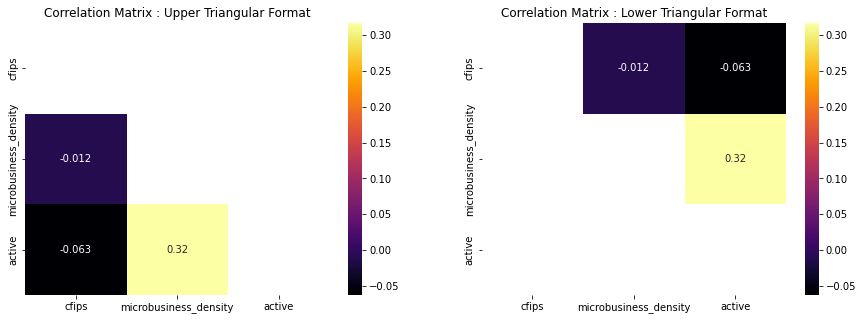

In [63]:
ut = np.triu(train.corr())
lt = np.tril(train.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

- As suspected, **active** displays a positive correlation of **0.32** with **microbusiness_density**.
- Hence, we will use :
    - **Endogenous Variable : microbusiness_density**
    - **Exogenous Variable : active**

In [64]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips', 'active']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density  active
cfips Date                                     
1001  2019-08-01                   3.01    1249
      2019-09-01                   2.88    1198
      2019-10-01                   3.06    1269
      2019-11-01                   2.99    1243
      2019-12-01                   2.99    1243

- We repeat the preprocessing steps from **Approach 2** w.r.t **cfips**.
- We now directly move onto the submission part as the model definition part has been repeated a lot.

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 5</div></center>

In [65]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

- We repeat the preprocessing process for **test data** w.r.t **cfips**.

## Non-Rolling Predictions :

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Predict Function : 

In [66]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x for x in df1.loc[i,'microbusiness_density'].values]
    exog_var = [x for x in df1.loc[i,'active'].values]
    
    model = ARIMA(history_p, order = (0,0,0), exog = exog_var) # AR - MA - ARMA
    model = ARIMA(history_p, order = (0,1,0), exog = exog_var) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_p,order = (0,1,0),seasonal_order = (0,1,0,12), exog = exog_var) # SARIMA
    model_fit = model.fit()
    
    f2 = np.array(model_fit.predict(start = 39,end = 46,typ = 'levels', exog = [exog_var[-1:-9:-1]]))

    for j in range(len(f2)):
        df2.loc[i, 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

In [67]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 6</div></center>

- In this approach, we combine **auto_arima** with endogenous & exogenous variables for the 3135 unique **cfips** based time series.
- **Exogenous variable** : It is a parallel time series that is not modeled directly but is used as a weighted input to the model. It is a variable that is correlated to the variable that we is being forecasted.
- **Endogenous variable** : It is a variable whose value is determined by the model i.e the main variable that we are forecasting values for.
- We know that **microbusiness_density** is being forecasted, hence it is the **Endogenous variable** whereas **active** is the potential **Exogenous variable**. We will check the autocorrelation graph to confirm.
- We use the **pmdarima** library to implement **auto_arima** and the same 4 versions of **auto_arima** utilized in **Approach 3**. 4 versions of **auto_arima** :
    - **Auto Arima : No Constraints - No Seasonality**
    - **Auto Arima : No Constraints - Seasonality**
    - **Auto Arima : Constraints - No Seasonality**
    - **Auto Arima : Constraints - Seasonality**

In [68]:
!pip install pmdarima --quiet
from pmdarima.arima import auto_arima

- Make sure that internet has been enabled.

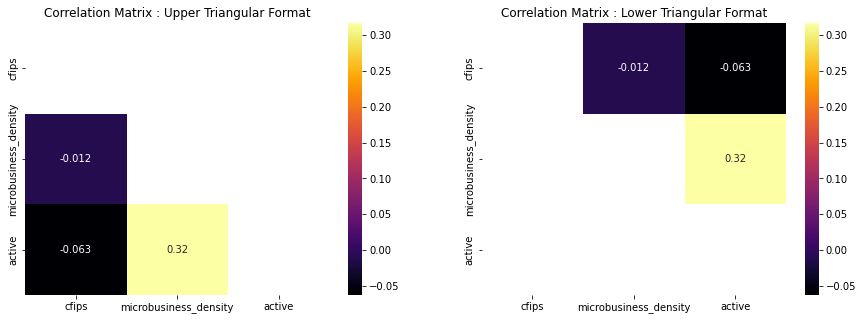

In [69]:
ut = np.triu(train.corr())
lt = np.tril(train.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

- As suspected, **active** displays a positive correlation of **0.32** with **microbusiness_density**.
- Hence, we will use :
    - **Endogenous Variable : microbusiness_density**
    - **Exogenous Variable : active**

In [70]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips','active']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density  active
cfips Date                                     
1001  2019-08-01                   3.01    1249
      2019-09-01                   2.88    1198
      2019-10-01                   3.06    1269
      2019-11-01                   2.99    1243
      2019-12-01                   2.99    1243

- We repeat the preprocessing steps from **Approach 2** w.r.t **cfips**.
- We have already seen the model definition part in **Approach 3**, hence we will directly move to the submission and highlight the use of exogenous variable.

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 6</div></center>

In [71]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

- We repeat the preprocessing process for **test data** w.r.t **cfips**.

## Non-Rolling Predictions :

#### Predict Function : 

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

- For the use of exogenous variables in **auto_arima**, we have to assign a 2-D array to the hyperparameter **X** in the model definition.
- Thus, we have created a varible named **exog_var** that stores the values of the **active** feature w.r.t the unique **cfips** values.
- We then reshape this variable to make sure that it's shape is 2-D.  

In [72]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[int(i),:].values]
    exog_var = np.array([x for x in df1.loc[i,'active'].values]); exog_var = exog_var.reshape((39,1))

    model = auto_arima(history_p, test = 'adf',seasonal = False, X = exog_var) # No Constraints - No Seasonality
        
    model = auto_arima(history_p, test = 'adf',seasonal = True, m = 12, X = exog_var) # No Constraints - Seasonality

    model = auto_arima(history_p, test = 'adf', X = exog_var,                         # Constraints - No Seasonality 
               start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
               seasonal = False, m = 1,
               start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
               trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

    model = auto_arima(history_p, test = 'adf', X = exog_var,                         # Constraints - Seasonality
               start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
               seasonal = True, m = 12,
               start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
               trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)

    f2 = model.predict(n_periods = 8, X = exog_var[-1:-9:-1])

    for j in range(len(df2.loc[i,:])):
        df2.loc[int(i), 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**

In [73]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

- We will now load the submission files of the 4 variations of the **auto_arima** model and submit to the competition.

In [74]:
submission = pd.read_csv('/kaggle/input/auto-arima-submission/1_exog_submission.csv') # No Constraints - No Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/2_exog_submission.csv') # No Constraints - Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/3_exog_submission.csv') # Constraints - No Seasonality
submission = pd.read_csv('/kaggle/input/auto-arima-submission/4_exog_submission.csv') # Constraints - Seasonality

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Approach 7</div></center>

- In this approach, we generate orders from **auto_arima** with endogenous & exogenous variables for the 3135 unique **cfips** based time series and forecast values using the models generated in **Approach 1**.
- **Exogenous variable** : It is a parallel time series that is not modeled directly but is used as a weighted input to the model. It is a variable that is correlated to the variable that we is being forecasted.
- **Endogenous variable** : It is a variable whose value is determined by the model i.e the main variable that we are forecasting values for.
- We know that **microbusiness_density** is being forecasted, hence it is the **Endogenous variable** whereas **active** is the potential **Exogenous variable**. We will check the autocorrelation graph to confirm.
- In this approach, models from the **Approach 1** will be utilized :
    - **Auto Regression (AR)**
    - **Moving Average (MA)**
    - **Auto Regressive Moving Average (ARMA)**
    - **Auto Regressive Integrated Moving Average (ARIMA)**
    - **Seasonal Auto Regressive Integrated Moving Average (SARIMA)**

In [75]:
!pip install pmdarima --quiet
from pmdarima.arima import auto_arima

- Make sure that internet has been enabled.

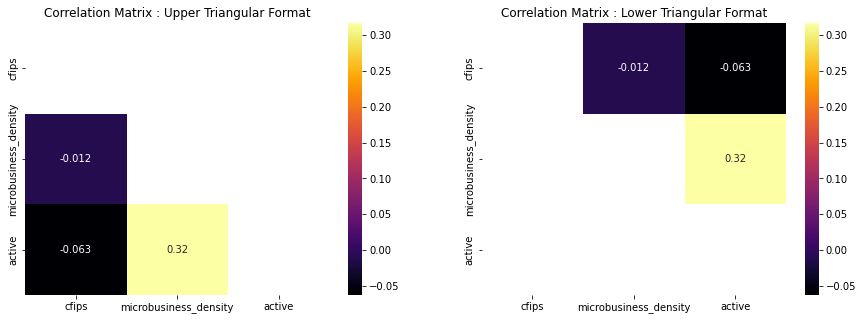

In [76]:
ut = np.triu(train.corr())
lt = np.tril(train.corr())

fig,ax = plt.subplots(nrows = 1, ncols = 2,figsize = (15,5))
plt.subplot(1,2,1)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = ut);
plt.title('Correlation Matrix : Upper Triangular Format');

plt.subplot(1,2,2)
sns.heatmap(train.corr(),cmap = 'inferno',annot = True,cbar = 'True',mask = lt);
plt.title('Correlation Matrix : Lower Triangular Format');

- As suspected, **active** displays a positive correlation of **0.32** with **microbusiness_density**.
- Hence, we will use :
    - **Endogenous Variable : microbusiness_density**
    - **Exogenous Variable : active**

In [77]:
df1 = train[['first_day_of_month', 'microbusiness_density','cfips','active']].copy(deep = True)
df1['Date'] = pd.to_datetime(df1['first_day_of_month'])
df1 = df1.drop(columns = 'first_day_of_month')

df1 = df1.groupby(['cfips','Date']).sum()
df1.head()

microbusiness_density  active
cfips Date                                     
1001  2019-08-01                   3.01    1249
      2019-09-01                   2.88    1198
      2019-10-01                   3.06    1269
      2019-11-01                   2.99    1243
      2019-12-01                   2.99    1243

- We repeat the preprocessing steps from **Approach 2** w.r.t **cfips**.
- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**

## <center>Auto Arima : No Constraints - No Seasonality</center>

In [78]:
d1 = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    exog_var = np.array([x for x in df1.loc[i,'active'].values]); exog_var = exog_var.reshape((39,1))
    model = auto_arima(history, test = 'adf',seasonal = False, X = exog_var)
    d1[i] = model.order

with open('arima_exog_order_nc_ns.pkl','wb') as f:
    pickle.dump(d1,f)
    
with open('/kaggle/input/auto-arima-submission/arima_exog_order_nc_ns.pkl', 'rb') as file:
    d1 = pickle.load(file)

## <center>Auto Arima : No Constraints - Seasonality</center>

In [79]:
d2 = {}; d2_seasonal = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    exog_var = np.array([x for x in df1.loc[i,'active'].values]); exog_var = exog_var.reshape((39,1))
    model = auto_arima(history, test = 'adf',seasonal = True, m = 12, X = exog_var)
    d2[i] = model.order; d2_seasonal[i] = model.seasonal_order

with open('arima_exog_order_nc_s.pkl','wb') as f:
    pickle.dump(d2,f)

with open('seasonal_arima_exog_order_nc_s.pkl','wb') as f:
    pickle.dump(d2_seasonal,f)
    
with open('/kaggle/input/auto-arima-submission/arima_exog_order_nc_s.pkl', 'rb') as file:
    d2 = pickle.load(file)
    
with open('/kaggle/input/auto-arima-submission/seasonal_arima_exog_order_nc_s.pkl', 'rb') as file:
    d2_seasonal = pickle.load(file)

## <center>Auto Arima : Constraints - No Seasonality</center>

In [80]:
d3 = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    exog_var = np.array([x for x in df1.loc[i,'active'].values]); exog_var = exog_var.reshape((39,1))
    model = auto_arima(history, test = 'adf', X = exog_var,      
            start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
            seasonal = False, m = 12,
            start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
            trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    d3[i] = model.order

with open('arima_exog_order_c_ns.pkl','wb') as f:
    pickle.dump(d3,f)
    
with open('/kaggle/input/auto-arima-submission/arima_exog_order_c_ns.pkl', 'rb') as file:
    d3 = pickle.load(file)

## <center>Auto Arima : Constraints - Seasonality</center>

In [81]:
d4 = {}
d4_seasonal = {}

for i in tqdm(train['cfips'].unique()):
    history = [x[0] for x in df1.loc[i,:].values]
    exog_var = np.array([x for x in df1.loc[i,'active'].values]); exog_var = exog_var.reshape((39,1))
    model = auto_arima(history, test = 'adf', X = exog_var,      
            start_p = 0, d = None, start_q = 0, max_p = 3, max_d = 1, max_q = 3, 
            seasonal = True, m = 12,
            start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, max_Q = 3,
            trace = False, error_action = 'ignore', suppress_warnings = True, stepwise = True)
    d4[i] = model.order ; d4_seasonal[i] = model.seasonal_order

with open('arima_exog_order_c_s.pkl','wb') as f:
    pickle.dump(d4,f)
    
with open('seasonal_arima_exog_order_c_s.pkl','wb') as f:
    pickle.dump(d4_seasonal,f)
    
with open('/kaggle/input/auto-arima-submission/arima_exog_order_c_s.pkl', 'rb') as file:  
    d4 = pickle.load(file)
    
with open('/kaggle/input/auto-arima-submission/seasonal_arima_exog_order_c_s.pkl', 'rb') as file:  
    d4_seasonal = pickle.load(file)

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Submission 7</div></center>

In [82]:
df2 = test.copy(deep = True)
df2['Date'] = pd.to_datetime(df2['first_day_of_month'])
df2 = df2.drop(columns = 'first_day_of_month')

df2 = df2.groupby(['cfips','Date']).sum()
df2.head()

row_id
cfips Date                       
1001  2022-11-01  1001_2022-11-01
      2022-12-01  1001_2022-12-01
      2023-01-01  1001_2023-01-01
      2023-02-01  1001_2023-02-01
      2023-03-01  1001_2023-03-01

- We repeat the preprocessing process for **test data** w.r.t **cfips**.

## Non-Rolling Predictions :

- **Note : The following code cells have been commented out and then executed! Hence, no output can be found!**
- **Note : In order to use the specific model that you want, comment out the remaining 4 models.**

#### Predict Function : 

In [83]:
df2['microbusiness_density'] = 0
for i in tqdm(train['cfips'].unique()):

    history_p = [x[0] for x in df1.loc[int(i),:].values]
    exog_var = [x for x in df1.loc[i,'active'].values]

    model = ARIMA(history_p, order = (d4[i][0],0,0), exog = exog_var) # AR
    model = ARIMA(history_p, order = (0,0,d4[i][2]), exog = exog_var) # MA
    model = ARIMA(history_p, order = (d4[i][0],0,d4[i][2]), exog = exog_var) # ARMA
    model = ARIMA(history_p, order = d4[i], exog = exog_var) # ARIMA
    model = sm.tsa.statespace.SARIMAX(history_p,order = d4[i],seasonal_order = d4_seasonal[i], exog = exog_var) # SARIMA
    model_fit = model.fit()
    
    f2 = np.array(model_fit.predict(start = 39,end = 46,typ = 'levels', exog = [exog_var[-1:-9:-1]]))

    for j in range(len(f2)):
        df2.loc[i, 'microbusiness_density'] = f2[j]
        
df2.index = range(0,len(test))

- Finally for submission, we create a complete new dataframe, create 2 columns : **row_id** & **microbusiness_density**. 
- Then, according to **row_id**, we assign values in the submission dataframe.

In [84]:
submission = pd.DataFrame({'row_id':sample['row_id'],'microbusiness_density': 0})
df2_row_id = list(df2['row_id'])

for i in range(len(submission['row_id'])):
    index = df2_row_id.index(submission.iloc[i,0])
    submission.iloc[i,1] = df2.iloc[index,1]

submission.to_csv('submission.csv',index = False)
submission

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Results Table</div></center>

## Approach 1 :

|Algorithm|Rolling Prediction|Non-Rolling Predicttion|
|-|-|-|
|AR|60.919|60.919|
|MA|60.919|60.919|
|ARMA|60.919|60.919|
|ARIMA|62.37|62.37|
|SARIMA|62.632|62.632|

## Approach 2 :

|Algorithm|Rolling Prediction|Non-Rolling Predicttion|
|-|-|-|
|AR|8.3574|8.3574|
|MA|8.3574|8.3574|
|ARMA|8.3574|8.3574|
|ARIMA|1.0935|1.0935|
|SARIMA|5.2456|5.1818|

## Approach 3 :

|Sr. No.|Algorithm|Auto Arima Non-Rolling Prediction|Execution Time|
|-|-|-|-|
|1|No Constraints - No Seasonality|4.8584|2 hrs 26 mins|
|2|No Constraints - Seasonality|5.0142|5 hrs 33 mins|
|3|Constraints - No Seasonality|2.1707|37 mins|
|4|Constraints - Seasonality|2.6398|2 hrs 30 mins|

## Approach 4 :

|Algorithm|No Constraints - No Seasonality|No Constraints - Seasonality|Constraints - No Seasonality|Constraints - Seasonality|
|-|-|-|-|-|
|AR|6.3231|6.6688|7.737|7.7283|
|MA|8.3348|8.3307|8.36|8.3602|
|ARMA|6.3689|6.6385|7.7489|7.7412|
|ARIMA|4.0935|4.0463|8.357|1.3673|
|SARIMA|-|5.0276|-|2.2764|

## Approach 5 :

|Algorithm|Non-Rolling Prediction|
|-|-|
|AR|5.2201|
|MA|5.2201|
|ARMA|5.2201|
|ARIMA|5.174|
|SARIMA|5.6481|

## Approach 6 :

|Sr. No.|Algorithm|Auto Arima Non-Rolling Prediction|
|-|-|-|
|1|No Constraints - No Seasonality|5.3195|
|2|No Constraints - Seasonality|5.5512|
|3|Constraints - No Seasonality|5.3338|
|4|Constraints - Seasonality|5.5153|

## Approach 7 :

|Algorithm|No Constraints - No Seasonality|No Constraints - Seasonality|Constraints - No Seasonality|Constraints - Seasonality|
|-|-|-|-|-|
|AR|5.2006|5.2117|5.2198|5.2183|
|MA|5.2155|5.2145|5.2204|5.2199|
|ARMA|5.1982|5.2081|5.2188|5.2179|
|ARIMA|5.301|5.3069|5.2277|5.2306|
|SARIMA|-|5.5128|-|5.4353|

# <center><div style="font-family: Times New Roman; border-radius : 10px; background-color: #000000; color: #00DDDE; padding: 12px; line-height: 1;">Conclusion</div></center>

## Approach 1 :

- All the models performed poorly on this competition dataset. Forecasts generated by the predict & function are the same!


- Most of the models have been initialized using the ARIMA as well! Due to the low unique date data, In-Sample Predictions was not carried out and as a result the model performances were poor as well.


- Presence of the significant lags was missing! Hence, most of the models turned into a random walk where algorithms become redundant! Thus, any approach using the above algorithms is not appropriate for the competition.

## Approach 2 :

- Clearly, the performances of all the models has been increased drastically due to the approach of building unique models for unique cfips values.


- On the flip side, time consumption of building 3135 unique models has increased alot. 


- As the order of the models has been the same for all the 3135 models of individual algorithms, convergence warnings became a recurring theme.

## Approach 3 :

- Model performance were ok. They were not successful in making a breakthrough in model performance set by the Approach 2.


- Time complexity of the models is a huge issue. This was expected as we were finding the perfect order for 3135 unique cfips value time series.


- Due to the performance of this approach, models need to be reevaluated. Combination of the models used in Approach 2 & Approach 3 can also be tried out. Nature of the data also needs to be critically looked at!

## Approach 4 :

- The approach utilized for creating a breakthrough in model performances did not work. Only 1 version of ARIMA model was close to record the same evaluation value to the models created in Approach 2.


- This approach of using orders generated by Auto-Arima and using them for other models generated convergence warnings indicating the models were not fit to their best orders.


- Time taken by Auto-Arima to generate orders were similar to the training time recorded by the models in Approach 3.

## Approach 5 :

- This approach did not yield the results that we expected. Use of endogenous - exogenous variables had a negative effect in this case.


- Convergence warning had popped up alot of times indicating the orders of the models require correction. We will try to use Auto Arima with endogenous & exogenous variables.

## Approach 6 :

- Approach of training Auto Arima model in combination with endogenous - exogenous variables was ineffective. 


- This was a high time consuming approach. Use of endogenous - exogenous variables forced us to use non-rolling methods for forecasting. Overall, given the results obtained in previous method, we can say that rolling and non-rolling methods were inseparable. 

## Approach 7 :

- This approach followed the trend of poor scores of model performances set by previous approaches.


- This approach was costly in terms of computation as well as time. Overall, this approach was wasteful as well!